# Example - Estimate Excess Surface Density with stacking strategy

we import some clmm modules

In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

clmm.__version__

'0.3.0'

we import `clmm` module's core.

In [2]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 

we import module for mock data

In [3]:
import mock_data as mock

basic modules

In [4]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we import `DC2Analysis` modules

In [5]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as st
import modelling as model

for reproductibility

In [6]:
np.random.seed(11)

we define cosmology into `Cosmology` object

In [7]:
mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

we define the `Modeling` object `moo` to for the galaxy cluster.

In [8]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Stacking` object `stack` by definning a given range of radial axis, the number of bins for the binned stacked shear profile.

In [9]:
stack = st.Stacking(r_low = 0.5,  r_up = 6, n_bins = 10, cosmo = mock_cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [10]:
deltasigma = True

In [11]:
stack._select_type(is_deltasigma = deltasigma)

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

In [12]:
z_bin = [0.4,0.5]
m_bin = [1*10**14, 1.2*10**14]
m_bin = np.array(m_bin)
n_catalogs = 50
ngals = 20000

we define a set of selected cluster with given true masses ans true redshifts

In [13]:
cluster_m = (m_bin[1] - m_bin[0])*np.random.random(n_catalogs) + m_bin[0] #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]

We add each galaxy catalogs that correponds to binning to the `stack` object

In [14]:
x_axis_list = []

gt_list = []

for i in range(n_catalogs):
    
    c = model.Duffy_concentration(cluster_m[i], cluster_z[i], moo)
    
    """Generate mock data"""
    
    data = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], c, mock_cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.1 ,shapenoise = 0.01,ngals=ngals)

    mock._compute_photoz_pdfs(data, 0.01)
    
    """Create GalaxyCluster object"""
    
    cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z[i], data)
    
    """Add tangential and cross components"""
    
    cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = deltasigma, cosmo = mock_cosmo)
    
    """Create profile"""
    
    profile = st.make_gt_profile(cl, stack.r_low, stack.r_up, stack.n_bins, stack.is_deltasigma, stack.cosmo)
    
    x_axis_list.append(profile['radius'])
    
    gt_list.append(profile['gt'])
    
    """Add catalog of background galaxies to stack"""
    
    stack._add_background_galaxies(cl, profile)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


we can see how much catalogs have been selected

In [15]:
print(f'we selected {stack.n_stacked_cluster} clusters')

we selected 50 clusters


The attribute `profile` of `shear` object is filled using the method `MakeShearProfile`, where the stacking method can be choosen as `'classical'` or weighted `'error weighted'`. The number of selected galaxy catalogs is visible with `n_stacked_gt` attribute

In [16]:
stack.MakeStackedProfile() 

The `profile` attribute of `stack`is an astropy table containing the binned profile `gt` along the radial axis `radius`

### Visualization of the results

we visualize the reduced tangential stacked shear and we calculate the predicted reduced shear when using the average innput mass of selected clusters. We also visualize individual shear profiles.

$$\Delta \Sigma(R) = \left(\frac{1}{\sum\limits_{l,s} w_{l,s}}\right)\sum\limits_{l,s} w_{l,s}\Sigma_c(z_s,z_l)e^t_{l,s}  \ at\ R$$

with : 
    $$
    w_{l,s} = 1/\Sigma_c(z_s,z_l)^2
    $$

we get the estimated shear signal by:

In [17]:
profile = stack.profile

we plot the results for the estimated stacked shear signal (in red) relatively to individual estimated shear signal from all the selected cluster

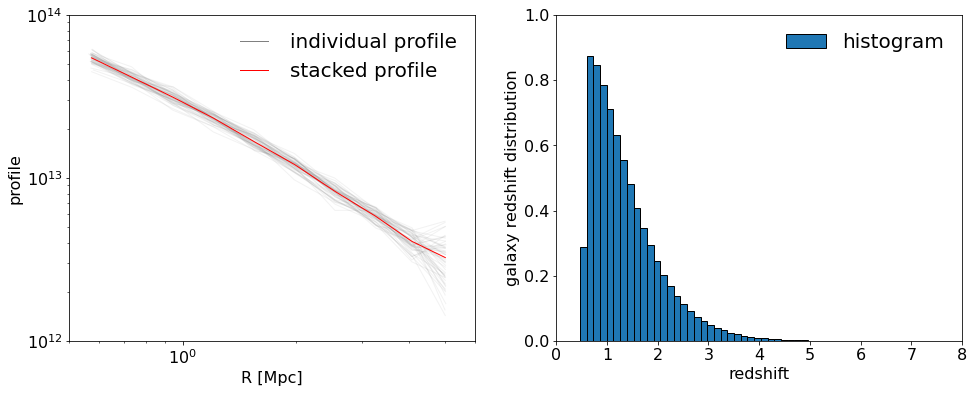

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.style.use('classic')
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)



for i in range(stack.n_stacked_cluster):
    
    axes[0].plot(x_axis_list[i],gt_list[i],c='grey',alpha=0.1)
    

axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].plot(profile['radius'], profile['gt'], 'r-', label='stacked profile')
axes[0].set_xlabel('R [Mpc]', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=False)
axes[0].semilogx()
axes[0].semilogy()
axes[0].set_ylim(10**12,10**14)
axes[0].set_xlim(stack.r_low, stack.r_up)
axes[1].hist(stack.z_galaxy_list, bins = 50,label='histogram', density = True)
axes[1].set_xlabel('redshift', fontsize=16)
axes[1].set_ylabel('galaxy redshift distribution', fontsize=16)
axes[1].legend(fontsize=20, frameon=False)
plt.show()